In [124]:
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Hyperparameter Sweeps

In [125]:
SWEEP_ENV = "MountainCar-v0" # "MountainCar-v0", "CartPole-v1", "Acrobot-v1"
SWEEP_STRAT = "adaptive"
NUM_SEEDS_PER_RUN = 3

LINEAR_PARAMS = ['schedule_timesteps', 'final_p', 'initial_p', 'schedule_type', 'lr', 'batch_size', 'base_config', 'env_name', 'target_update_period', 'total_steps']
ADAPTIVE_PARAMS = ['alpha', 'n', 'p', 'threshold', 'eps_max', 'schedule_type', 'lr', 'batch_size', 'base_config', 'env_name', 'target_update_period', 'total_steps']
SINE_PARAMS = ['schedule_timesteps', 'final_p', 'initial_p', 'period_frac', 'schedule_type', 'lr', 'batch_size', 'base_config', 'env_name', 'target_update_period', 'total_steps']

if SWEEP_STRAT == "linear": SWEEP_PARAMS = LINEAR_PARAMS
elif SWEEP_STRAT == "adaptive": SWEEP_PARAMS  = ADAPTIVE_PARAMS
elif SWEEP_STRAT == "sinusoidal": SWEEP_PARAMS = SINE_PARAMS


In [126]:
import numpy as np

def load_data(log_file, value='eval_return'):
    event_acc = EventAccumulator(log_file)
    event_acc.Reload()
    values = event_acc.Scalars(value)
    env_steps = [
        e.step for e in values
    ]
    values = [
        e.value for e in values
    ]
    return np.array(env_steps), np.array(values)

def smooth_data(data, n):
    smoothed_data = []
    for i in range(len(data)):
        ds = data[max(i-n, 0): i+1]
        smoothed_data.append(sum(ds) / len(ds))
    return smoothed_data

In [127]:
def plot(log_files, value='eval_return', label="", std=False, smooth=0):
    xs, ys = [], []
    for log_file in log_files:
        x, y = load_data(log_file, value=value)
        xs.append(x)
        ys.append(y)

    x = np.array(xs).mean(axis=0)
    y = np.array(ys).mean(axis=0)
    
    if smooth:
        y = smooth_data(y, smooth)
    if std:
        y_std = np.array(ys).std(axis=0)    
        plt.fill_between(x, y-y_std, y+y_std, alpha=0.2)
        
    plt.plot(x, y, "-", label=label)
    plt.xlabel("timesteps")
    plt.ylabel(value)

In [128]:
# Do not run, this will mess up the indices used later
path_prefix = SWEEP_ENV + "_" + SWEEP_STRAT + "_"
paths = [os.path.join("data", filename) for filename in os.listdir(f"data") if filename[:len(path_prefix)] == path_prefix]

event_acc = EventAccumulator(paths[0])
event_acc.Reload()
TAGS = event_acc.Tags()["scalars"]
print("Tags:")
for tag in TAGS:
    print(tag)

Tags:
eval_return
eval_ep_len
eval/return_std
eval/return_max
eval/return_min
eval/ep_len_std
eval/ep_len_max
eval/ep_len_min
train_return
train_ep_len
critic_loss
q_values
target_values
grad_norm
epsilon
lr


In [129]:
print("Number of Runs Found:", len(paths))

Number of Runs Found: 75


In [130]:
def path_timestamp(path):
    t = path.split("seed")[1]
    seed, date, time = t.split("_")[1:]
    date = "".join(date.split("-")[::-1])
    time = time.replace("-", "")
    return int(date + time + seed)

paths = sorted(paths, key=path_timestamp)
paths = [[paths[i+n] for n in range(NUM_SEEDS_PER_RUN) if i+n < len(paths)] for i in range(0, len(paths), NUM_SEEDS_PER_RUN)] 

In [131]:
import difflib

def reconstruct_sweep(paths):
    sweep = []
    prev_runs = paths[0]
    prev_run = paths[0][0]

    for itr, runs in enumerate(paths[1:]):
        run = runs[0]
        
        prev_params = prev_run.replace("data/" + path_prefix, "").split("_seed")[0]
        params = run.replace("data/" + path_prefix, "").split("_seed")[0]
        
        flg = False
        for i, s in enumerate(difflib.ndiff(prev_params, params)):
            if s[0] == " ": continue
            else:
                flg = True
                break
        
        s = ""
        if flg:
            while prev_params[i] != "_":
                i -= 1
            while s not in SWEEP_PARAMS:
                i -= 1
                s = prev_params[i] + s
            v = params.split(s + "_")[1].split("_")[0]
        else:
            v = ""
    
        if len(sweep) > 0:
            p, r = sweep[-1]
            if p == s:
                if v not in r:
                    r[v] = runs
                else:
                    sweep.append(["", {v: runs}])
            elif p == "":
                sweep[-1][0] = s
                temp_v = list(r.keys())[0]
                true_v = r[temp_v][0].split(s + "_")[1].split("_")[0]
                if temp_v != true_v:
                    r[true_v] = r[temp_v]
                    del r[temp_v]
                r[v] = runs
            else:
                sweep.append([s, {v: runs}])
        else:
            prev_v = prev_params.split(s + "_")[1].split("_")[0]
            sweep.append([s, {prev_v: prev_runs, v: runs}])
        
        prev_runs = runs
        prev_run = run
    
    return sweep
        
sweep = reconstruct_sweep(paths)
print("Sweep Reconstruction:")
for p, r in sweep:
    print("--------------------------------------------------------------------------------------------")
    print(f"Sweeping: {p}, Values: {', '.join(r.keys())}")
    print("--------------------------------------------------------------------------------------------")

Sweep Reconstruction:
--------------------------------------------------------------------------------------------
Sweeping: alpha, Values: 0.99, 0.01, 0.2, 0.5
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Sweeping: p, Values: 0.1, 0.01, 0.05, 0.25
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Sweeping: threshold, Values: 0.01, 0.1, 0.2, 0.4
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
Sweeping: eps_max, Values: 0.5, 0.1, 0.3, 0.7
--------------------------------------------------------------------------------------------
--------------------------------------------------

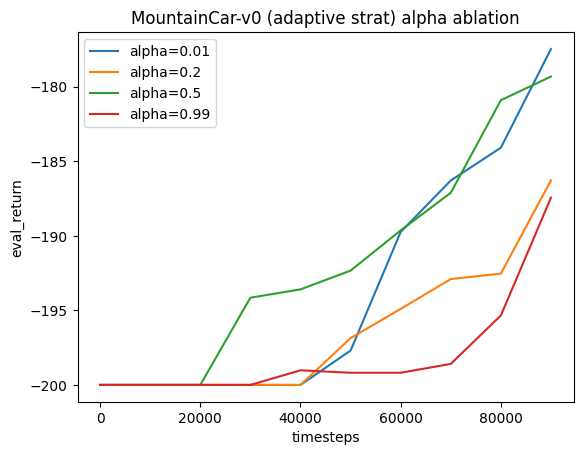

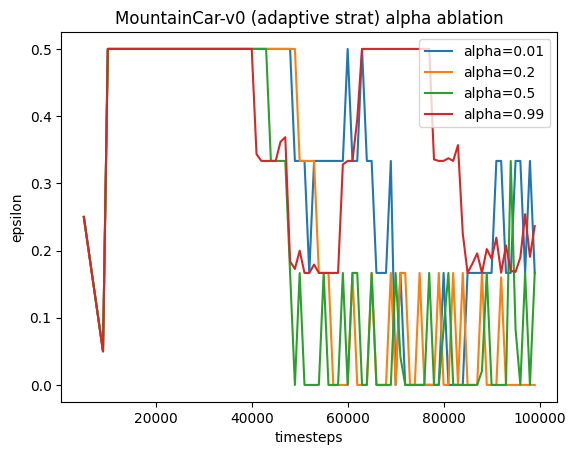

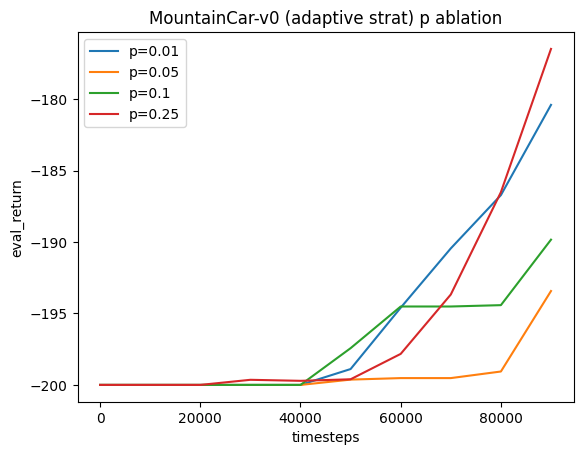

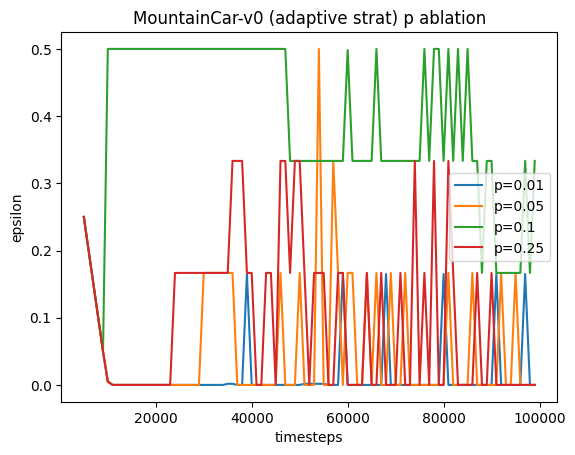

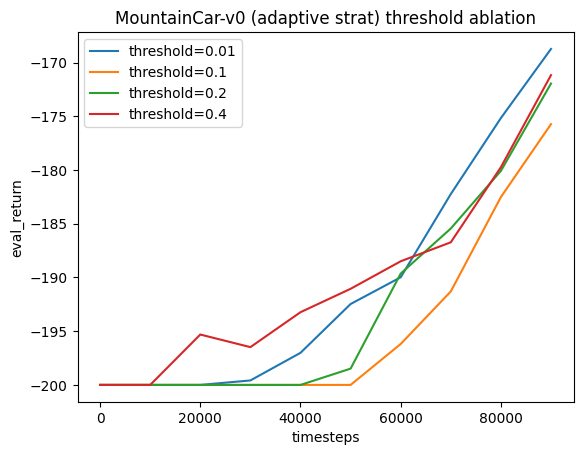

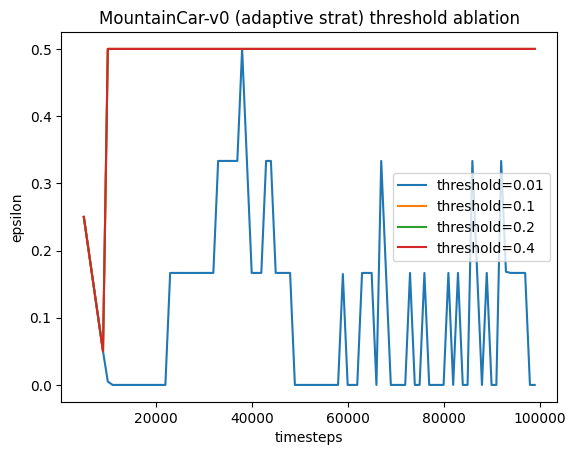

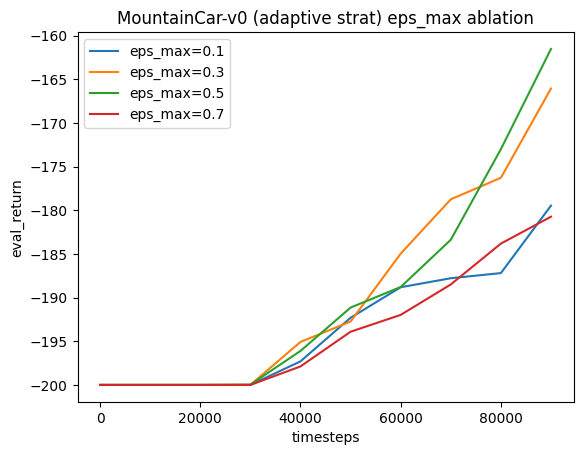

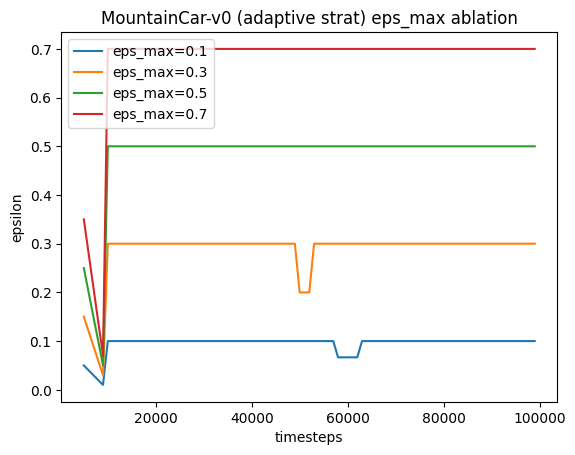

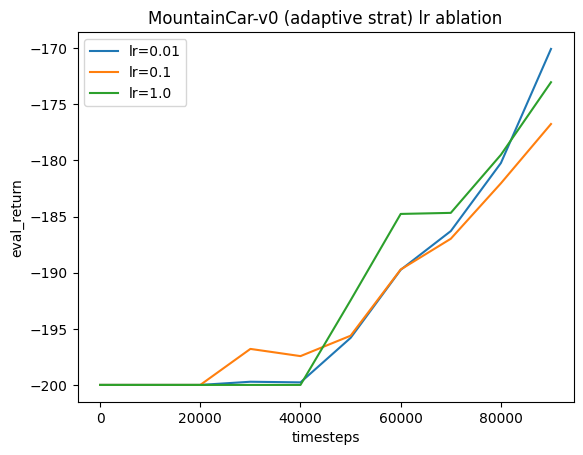

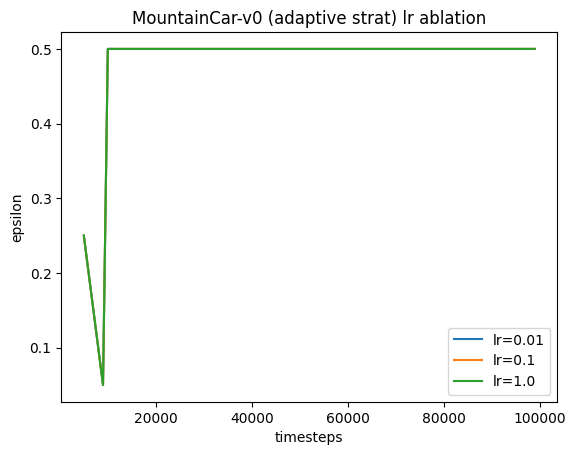

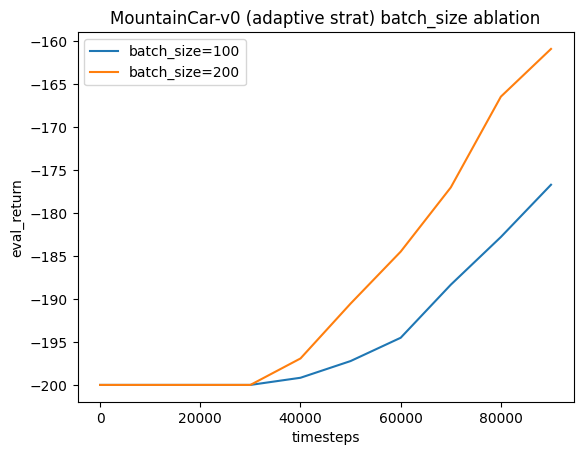

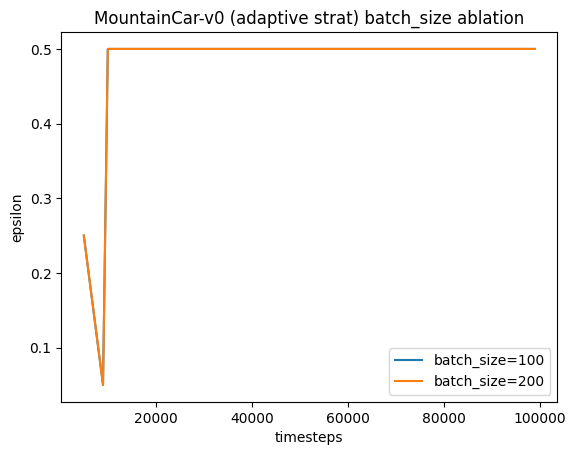

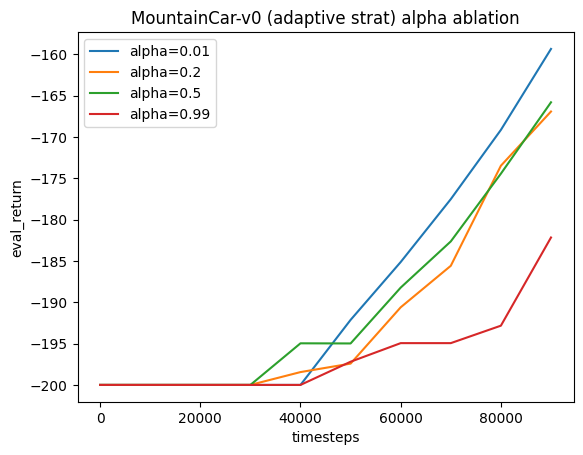

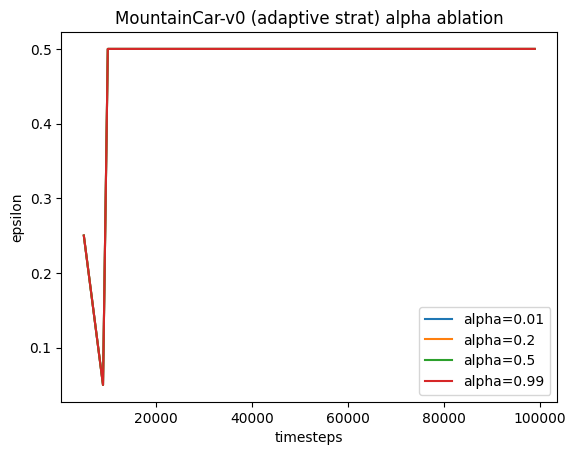

In [134]:
for param_name, param_runs in sweep:
    
    param_vals = list(param_runs.keys())
    try:
        float(param_vals[0])
        param_vals = sorted(param_vals, key=float)    
    except:
        pass
    
    plt.title(f"{SWEEP_ENV} ({SWEEP_STRAT} strat) {param_name} ablation")
    for param_val in param_vals:
        runs = param_runs[param_val]
        try:
            plot(runs, value="eval_return", label=f"{param_name}={param_val}", std=False, smooth=5)
        except:
            pass
    plt.legend()
    plt.show()
    
    plt.title(f"{SWEEP_ENV} ({SWEEP_STRAT} strat) {param_name} ablation")
    for param_val in param_vals:
        runs = param_runs[param_val]
        try:
            plot(runs, value="epsilon", label=f"{param_name}={param_val}", std=False, smooth=0)
        except:
            pass
    plt.legend()
    plt.show()


In [135]:
print(sweep[-1])

['alpha', {'0.99': ['data/MountainCar-v0_adaptive_lr_0.01_batch_size_100_base_config_dqn_basic_target_update_period_1000_total_steps_100000_alpha_0.99_n_10000_p_0.25_threshold_0.1_eps_max_0.5_MountainCar-v0_s64_l2_d0.99_seed_1_11-12-2023_19-21-13', 'data/MountainCar-v0_adaptive_lr_0.01_batch_size_100_base_config_dqn_basic_target_update_period_1000_total_steps_100000_alpha_0.99_n_10000_p_0.25_threshold_0.1_eps_max_0.5_MountainCar-v0_s64_l2_d0.99_seed_2_11-12-2023_19-27-13', 'data/MountainCar-v0_adaptive_lr_0.01_batch_size_100_base_config_dqn_basic_target_update_period_1000_total_steps_100000_alpha_0.99_n_10000_p_0.25_threshold_0.1_eps_max_0.5_MountainCar-v0_s64_l2_d0.99_seed_3_11-12-2023_19-33-14'], '0.01': ['data/MountainCar-v0_adaptive_lr_0.01_batch_size_100_base_config_dqn_basic_target_update_period_1000_total_steps_100000_alpha_0.01_n_10000_p_0.25_threshold_0.1_eps_max_0.5_MountainCar-v0_s64_l2_d0.99_seed_1_11-12-2023_19-39-14', 'data/MountainCar-v0_adaptive_lr_0.01_batch_size_100_b